# Train a FF network

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from nmp import plotter
from pathlib import Path
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import random
import copy
import tensorflow as tf

NOTES = '-' + 'no-down'
# NOTES = '-' + 'ff'

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
P2 = Path('S:\datasets')  # Dataset path

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 1  # Downsampling factor

D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
# D = "data/JSB Chorales"  # Dataset

# 64 notes
# LOW_LIM = 33  # A1
# HIGH_LIM = 97  # C7

# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# Complete 88-key keyboard
LOW_LIM = 21  # A0
HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

LOAD = 0
TRANS = 0

Using TensorFlow backend.


### Generate list of MIDI files

In [2]:
train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
validation_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]
test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]

print("\nTrain list:  ", train_list)
print("\nValidation list:  ", validation_list)
print("\nTest list:  ", test_list)


Train list:   ['alb_esp1.mid', 'alb_esp3.mid', 'alb_esp4.mid', 'alb_esp6.mid', 'alb_se1.mid', 'alb_se2.mid', 'alb_se3.mid', 'alb_se4.mid', 'alb_se6.mid', 'alb_se7.mid', 'appass_1.mid', 'appass_2.mid', 'appass_3.mid', 'bach_850.mid', 'bor_ps1.mid', 'bor_ps2.mid', 'bor_ps3.mid', 'bor_ps6.mid', 'bor_ps7.mid', 'br_im2.mid', 'br_im5.mid', 'br_rhap.mid', 'burg_gewitter.mid', 'burg_perlen.mid', 'chpn-p10.mid', 'chpn-p2.mid', 'chpn-p22.mid', 'chpn-p6.mid', 'chpn_op25_e4.mid', 'chpn_op33_2.mid', 'chpn_op33_4.mid', 'chpn_op7_1.mid', 'chpn_op7_2.mid', 'deb_pass.mid', 'deb_prel.mid', 'gra_esp_2.mid', 'gra_esp_3.mid', 'grieg_kobold.mid', 'grieg_voeglein.mid', 'grieg_waechter.mid', 'hay_40_1.mid', 'islamei.mid', 'liz_et1.mid', 'liz_et2.mid', 'liz_et3.mid', 'liz_et4.mid', 'liz_et5.mid', 'mendel_op30_1.mid', 'mendel_op62_3.mid', 'mendel_op62_4.mid', 'mond_1.mid', 'mond_3.mid', 'muss_1.mid', 'muss_3.mid', 'muss_5.mid', 'muss_6.mid', 'muss_7.mid', 'muss_8.mid', 'mz_330_1.mid', 'mz_330_2.mid', 'mz_330_3

## Datasets

### Generate data from lists
Training, validation and test sets.

In [4]:
start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0, quant=Q)
validation = dataset.Dataset(validation_list, P / D / 'valid',  fs=FS, bl=0, quant=Q)
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)

train.build_dataset("training", step=st, t_step=num_ts, steps=st,
                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_dataset("validation", step=st, t_step=num_ts, steps=st,
                         down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.build_dataset("test", step=st, t_step=num_ts, steps=st,
                   down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done")
print("Loading time: %.2f" % (end-start))

Building training dataset (87 files)
Building validation dataset (12 files)
Building test dataset (25 files)
Done
Loading time: 138.71


In [5]:
print(train.dataset[0].shape)
print(train.dataset[1].shape)

(960075, 10, 88)
(960075, 880)


### Save dataset

In [6]:
# np.save(P2 / '64-18-step' / 'train.input', train.dataset[0], allow_pickle=True)
# np.save(P2 / '64-18-step' / 'train.target', train.dataset[1], allow_pickle=True)
# np.save(P2 / '64-18-step' / 'valid.input', validation.dataset[0], allow_pickle=True)
# np.save(P2 / '64-18-step' / 'valid.target', validation.dataset[1], allow_pickle=True)
# np.save(P2 / '64-18-step' / 'test.input', test.dataset[0], allow_pickle=True)
# np.save(P2 / '64-18-step' / 'test.target', test.dataset[1], allow_pickle=True)

### Piano rolls of training dataset
Input and output piano rolls

(21.0, 109.0)

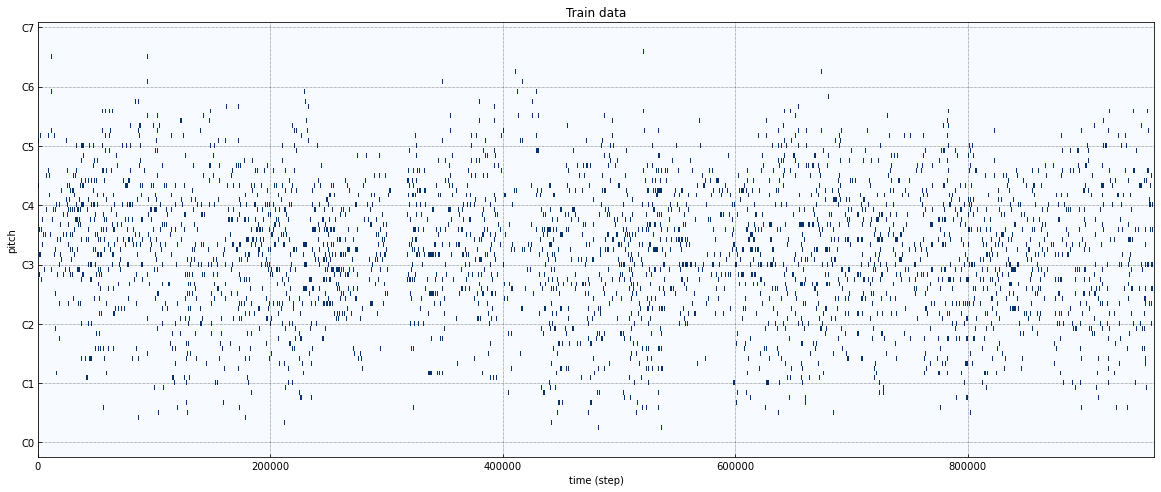

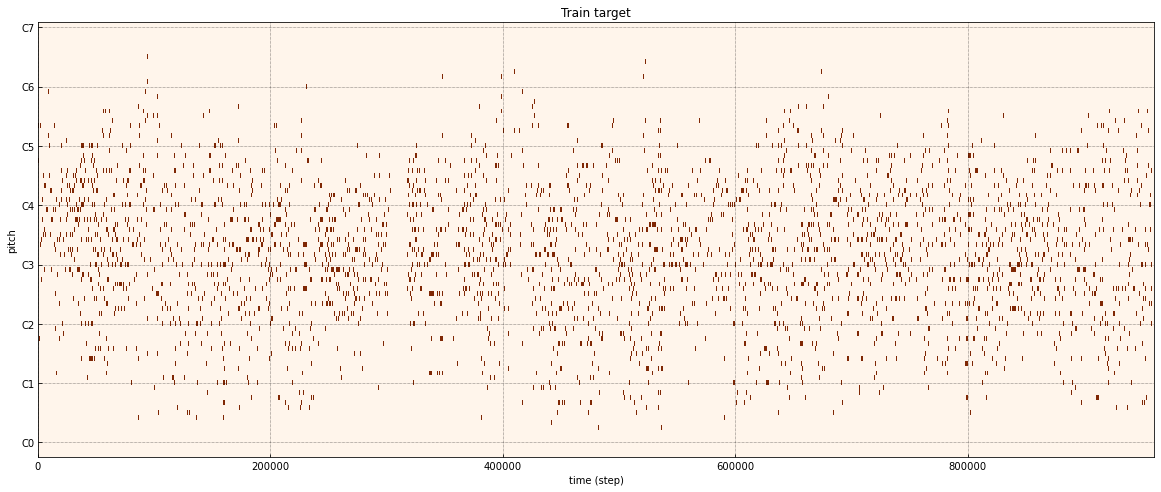

In [7]:
plt.rcParams["figure.figsize"] = (20, 8)
pyplot_piano_roll(train.dataset[0][:, 0, :],
                  low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Train data")
plt.ylim(CROP)
pyplot_piano_roll(train.dataset[1][:, :NUM_NOTES], cmap="Oranges",
                  low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Train target")
plt.ylim(CROP)

## Keras
### Build the model

In [8]:
LOAD = 0
model_path = str(P / 'models' / 'model-down-trans-64-4-20epochs')
BS = 64  # Batch size
import importlib
importlib.reload(mod)
importlib.reload(dataset)
import time

In [9]:
# L = train.dataset[0].shape[0]
# L -= L % BS
# x = train.dataset[0][:L, :, :]
# y = train.dataset[1][:L, :]
# train.dataset = (x, y)

# L = validation.dataset[0].shape[0]
# L -= L % BS
# x = validation.dataset[0][:L, :, :]
# y = validation.dataset[1][:L, :]
# validation.dataset = (x, y)

# train.dataset[0].shape

In [10]:
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])

model.summary()

now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2848      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 880)               29040     
Total params: 42,160
Trainable params: 42,160
Non-trainable params: 0
_________________________________________________________________


### Checkpoints

In [11]:
# Directory where the checkpoints will be saved
checkpoint_dir = P / ('models/training_checkpoints/' + now.strftime("%Y%m%d-%H%M%S"))
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    period=1)

### Fit the model
Define batch size ```BS``` and number of ```epochs```

#### Fit with reset_state

In [12]:
# # Fit generator the model.
# random.seed(40)
# epochs = 1
# start = time.time()
# train_loss = []
# train_acc = []
# val_loss = []

# size_valid = math.floor(validation.dataset[0].shape[0] / BS)
# spe_valid = size_valid

# cnt = 0
# choice = list(range(len(train.data)))
# for _ in range(20):  # Epochs
#     random.shuffle(choice)
#     print("List: ", choice)
#     song = 0
#     train_song_loss = []
#     train_song_acc = []
#     val_song_loss = []
#     last_song = 0
    
#     for i in choice:
# #         print("song", i)
#         x = copy.deepcopy(train.data[i])
#         y = copy.deepcopy(train.targets[i])
#         song += 1
#         if song == len(train.data):
#             last_song = 1
        
#         size_train = math.floor(len(x) / BS)
#         spe_train = math.floor(size_train / 10)

#         if not last_song:
#             history = model.fit(dataset.generate_stateful((x[:size_train*BS, :, :],
#                                                            y[:size_train*BS, :]), bs=BS, trans=1), epochs=epochs,
#                                 steps_per_epoch=spe_train, verbose=0)    
# #             print("s", song)
                   
#         else:
#             history = model.fit(dataset.generate_stateful((x, y), bs=BS, trans=1), epochs=epochs,
#                       steps_per_epoch=spe_train,
#                       validation_data=dataset.generate((validation.dataset[0][:size_valid*BS, :, :],
#                                                         validation.dataset[1][:size_valid*BS, :]), bs=BS),
#                       validation_steps=spe_valid, verbose=1)
#             print("Epoch %d finished" % cnt)
#             cnt += 1

#             train_song_loss.append(history.history['loss'])
#             train_song_acc.append(history.history['accuracy'])
#             val_song_loss.append(history.history['val_loss'])


        
#         model.reset_states()
    
#     train_loss.append(np.mean(train_song_loss))
#     train_acc.append(np.mean(train_song_acc))
#     val_loss.append(np.mean(val_song_loss))
    
#     end = time.time()

In [ ]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))
# plt.plot(val_loss, 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
# plt.plot(train_loss, 'o-', c='tab:red', label='Train', ms=8, alpha=0.8)
# plt.xlabel('Epoch')
# plt.xticks(range(epochs))
# plt.legend()
# plt.title('Loss: Binary cross-entropy')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.ylim([0.000, 0.30])
# fig.savefig(PLOTS / 'lossLSTMDe.eps', fmt='eps')
# print("Training time: ", (end-start))

#### train_on_batch

In [ ]:
# # Train on batch the model.
# BS = 5  # Batch size
# epochs = 3
# start = time.time()
# history = {'train': [], 'test': []}
# for e in range(epochs):
#     print("Epoch %d" % e)
#     data_generator = dataset.generate_on_batch((train.data, train.targets), bs=BS, trans=1)
#     while True:
#         try:
#             (x, y) = next(data_generator)
# #             print("Sample")
# #             time.sleep(.5)

#             if x[0][0][0] >= 0:
#                 history['train'].append(model.train_on_batch(x, y))
#             else:
# #                 print("Resetting state...")
#                 model.reset_states()

#         except Exception:
#             print("Epoch %d finished!" % e)
#             break

# end = time.time()

In [ ]:
# data_generator = dataset.generate_on_batch((test.data, test.targets), bs=BS, trans=1)
# while True:
#     try:
#         (x, y) = next(data_generator)

#         if x[0][0][0] >= 0:
#             history['test'].append(model.train_on_batch(x, y))
#         else:
#             model.reset_states()
#     except Exception:
#         break

In [ ]:
# plt.figure(constrained_layout=True)
# plt.plot(history['train'])
# plt.legend(['Loss', 'Accuracy'])

# plt.figure(constrained_layout=True)
# plt.plot(history['test'])
# plt.legend(['Loss', 'Accuracy'])
# plt.show()

#### fit generator

In [13]:
# Fit generator the model.
epochs = 20
start = time.time()
size_train = math.ceil(train.dataset[0].shape[0] / BS)
spe_train = size_train
size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
spe_valid = size_valid
print("Train dataset shape: ", train.dataset[0].shape, "\n")
print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# Fit generator. Data should be shuffled before fitting.
history = model.fit(dataset.generate((train.dataset[0], train.dataset[1]), trans=1), epochs=epochs,
          steps_per_epoch=spe_train,
          validation_data=dataset.generate((validation.dataset[0], validation.dataset[1])),
          validation_steps=spe_valid,
          callbacks=[logger, csv_logger, checkpoint_callback])

end = time.time()

Train dataset shape:  (960075, 10, 88) 

Train dataset target shape:  (960075, 880) 

Train for 15002 steps, validate for 1738 steps
Epoch 1/20
15002/15002 [==============================] - 64s 4ms/step - loss: 0.0704 - accuracy: 0.9788 - f1: 0.5845 - precision_1: 0.6622 - recall_1: 0.3631 - val_loss: 0.0714 - val_accuracy: 0.9780 - val_f1: 0.6321 - val_precision_1: 0.7500 - val_recall_1: 0.5069
Epoch 2/20
15002/15002 [==============================] - 63s 4ms/step - loss: 0.0614 - accuracy: 0.9813 - f1: 0.6713 - precision_1: 0.7532 - recall_1: 0.5353 - val_loss: 0.0706 - val_accuracy: 0.9783 - val_f1: 0.6325 - val_precision_1: 0.7556 - val_recall_1: 0.5531
Epoch 3/20
15002/15002 [==============================] - 62s 4ms/step - loss: 0.0608 - accuracy: 0.9815 - f1: 0.6766 - precision_1: 0.7569 - recall_1: 0.5627 - val_loss: 0.0700 - val_accuracy: 0.9785 - val_f1: 0.6436 - val_precision_1: 0.7577 - val_recall_1: 0.5705
Epoch 4/20
15002/15002 [==============================] - 63s 4ms/

#### fit

In [ ]:
# # Fit the model.

# BS = 64  # Batch size
# epochs = 25
# start = time.time()
# # size_train = math.ceil(train.dataset[0].shape[0] / BS)
# # spe_train = size_train #+ size_train*10
# # size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# # spe_valid = size_valid #+ size_valid*10
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Normal fit. Auto-shuffles data.
# history = model.fit(x=train.dataset[0], y=train.dataset[1],
#                     epochs=epochs, batch_size=BS, shuffle=True,
#                     validation_data=(validation.dataset[0],
#                                      validation.dataset[1]),
#                     callbacks=[logger, csv_logger])

# end = time.time()






# # Fit the model.
# BS = 64  # Batch size
# epochs = 25
# start = time.time()
# # size_train = math.ceil(train.dataset[0].shape[0] / BS)
# # spe_train = size_train #+ size_train*10
# # size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# # spe_valid = size_valid #+ size_valid*10
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Normal fit. Auto-shuffles data.
# history = model.fit(x, epochs=epochs, shuffle=True,
#                     validation_data=(validation.dataset[0],
#                                      validation.dataset[1]),
#                     callbacks=[logger, csv_logger])

# end = time.time()

### History

```f1_first```: F1-score on first predicted timestep

```f1_last```: F1-score on last predicted timestep

In [14]:
print("\nTraining time: ", (end-start), "\n")
hist = pd.DataFrame(history.history)
print(hist)


Training time:  1277.8668332099915 

        loss  accuracy        f1  precision_1  recall_1  val_loss  \
0   0.070376  0.978803  0.584516     0.662190  0.363072  0.071364   
1   0.061374  0.981287  0.671302     0.753218  0.535344  0.070551   
2   0.060777  0.981497  0.676593     0.756859  0.562747  0.070020   
3   0.060485  0.981601  0.679142     0.758272  0.575786  0.069845   
4   0.060285  0.981669  0.680764     0.759358  0.583287  0.069822   
5   0.060131  0.981727  0.681957     0.760148  0.588486  0.069349   
6   0.060027  0.981756  0.682720     0.760543  0.592294  0.069587   
7   0.059945  0.981780  0.683160     0.760758  0.595412  0.069525   
8   0.059870  0.981800  0.683700     0.761275  0.597770  0.069302   
9   0.059813  0.981818  0.684073     0.761457  0.599644  0.069605   
10  0.059766  0.981824  0.684274     0.761683  0.601034  0.069342   
11  0.059726  0.981839  0.684538     0.761829  0.602349  0.069083   
12  0.059695  0.981849  0.684761     0.762200  0.603481  0.069574

### Plot loss function of training and validation sets

Training time:  1277.8668332099915


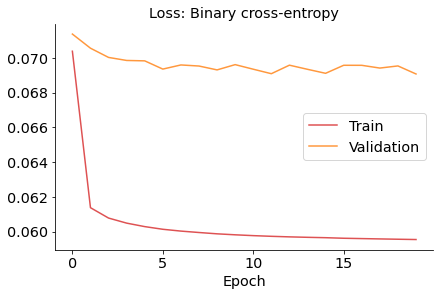

In [15]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['loss'], '-', c='tab:red', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_loss'], '-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Loss: Binary cross-entropy', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'comp-ff-loss.pdf')
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

In [16]:
# hist['loss'].to_csv(('tables/ff-' + D[5:] + '-loss-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_loss'].to_csv(('tables/ff-' + D[5:] + '-loss-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['f1'].to_csv(('tables/ff-' + D[5:] + '-f1-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_f1'].to_csv(('tables/ff-' + D[5:] + '-f1-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['precision_1'].to_csv(('tables/ff-' + D[5:] + '-precision-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_precision_1'].to_csv(('tables/ff-' + D[5:] + '-precision-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['recall_1'].to_csv(('tables/ff-' + D[5:] + '-recall-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_recall_1'].to_csv(('tables/ff-' + D[5:] + '-recall-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

Training time:  1277.8668332099915


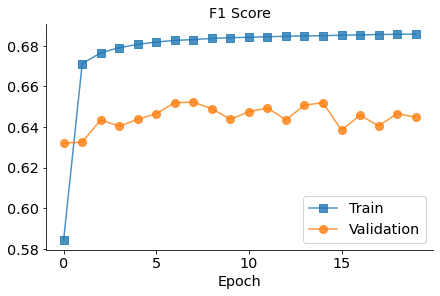

In [17]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['f1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_f1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('F1 Score', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'f120480.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

Training time:  1277.8668332099915


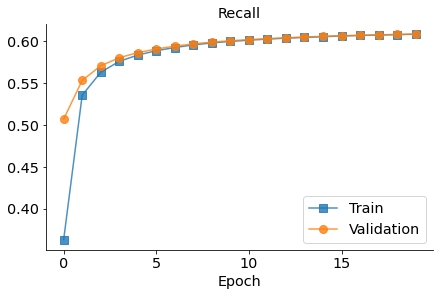

In [18]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['recall_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_recall_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Recall', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'recall.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

Training time:  1277.8668332099915


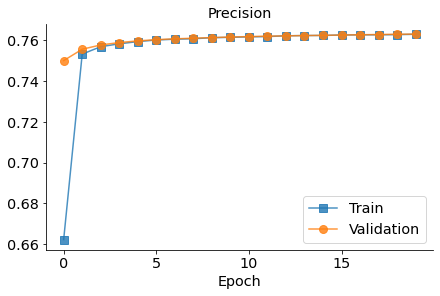

In [19]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['precision_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_precision_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Precision', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'precision.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

## Save model to file
Model can be loaded with:
``` python
load_model(filepath=str(folder_path), compile=True)
```

In [ ]:
# model.save(str(P / 'models' / 'ff-z2-de'))
# model.save(str(P / 'models' / 'lstm-z-de') + '.h5', save_format='h5')

In [ ]:
model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

### Model evaluation

In [20]:
print("Evaluation on train set:")
e_train = model.evaluate(x=train.dataset[0],
                         y=train.dataset[1],
                         batch_size=BS)

print("\nEvaluation on validation set:")
e_valid = model.evaluate(x=validation.dataset[0],
                         y=validation.dataset[1],
                         batch_size=BS)

print("\nEvaluation on test set:")
e_test = model.evaluate(x=test.dataset[0],
                        y=test.dataset[1],
                        batch_size=BS)

results = {out: e_train[i] for i, out in enumerate(model.metrics_names)}
res = pd.DataFrame(list(results.items()), columns=['metric', 'train'])
res = res.set_index('metric')

results2 = {out: e_valid[i] for i, out in enumerate(model.metrics_names)}
res2 = pd.DataFrame(list(results2.items()), columns=['metric', 'validation'])
res2 = res2.set_index('metric')

results3 = {out: e_test[i] for i, out in enumerate(model.metrics_names)}
res3 = pd.DataFrame(list(results3.items()), columns=['metric', 'test'])
res3 = res3.set_index('metric')


result = pd.concat([res, res2, res3], axis=1, sort=False)
result

Evaluation on train set:
960075/960075 [==============================] - 37s 38us/sample - loss: 0.0595 - accuracy: 0.9819 - f1: 0.6014 - precision_1: 0.7631 - recall_1: 0.6085

Evaluation on validation set:
111204/111204 [==============================] - 4s 39us/sample - loss: 0.0693 - accuracy: 0.9786 - f1: 0.5861 - precision_1: 0.7632 - recall_1: 0.6087

Evaluation on test set:
212837/212837 [==============================] - 8s 39us/sample - loss: 0.0626 - accuracy: 0.9808 - f1: 0.5951 - precision_1: 0.7631 - recall_1: 0.6084


,train,validation,test
metric,,,
loss,0.059466,0.069345,0.062625
accuracy,0.981917,0.978640,0.980775
f1,0.601437,0.586145,0.595075
precision_1,0.763137,0.763242,0.763126
recall_1,0.608504,0.608674,0.608413


### Make predictions
Predictions from test dataset

(21.0, 109.0)

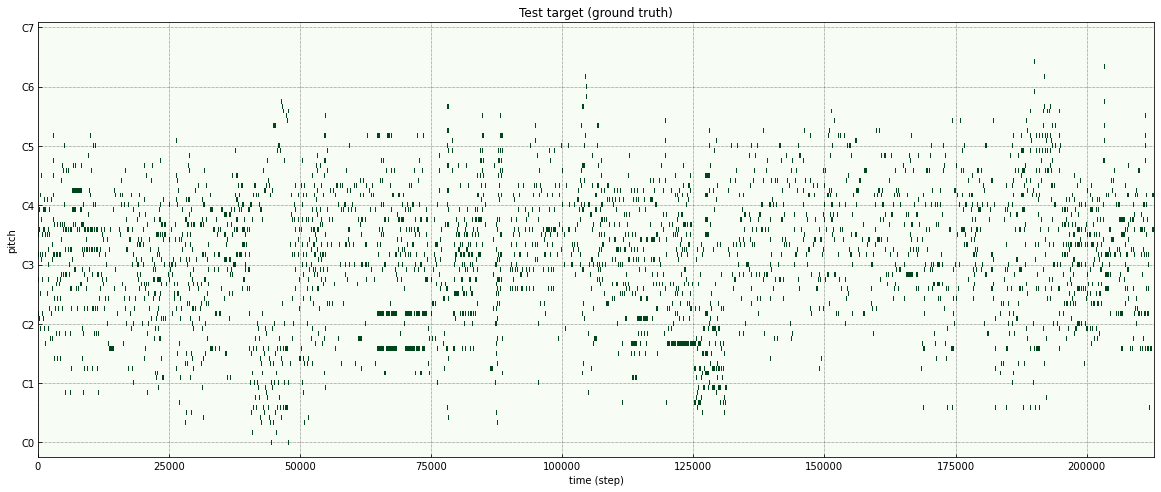

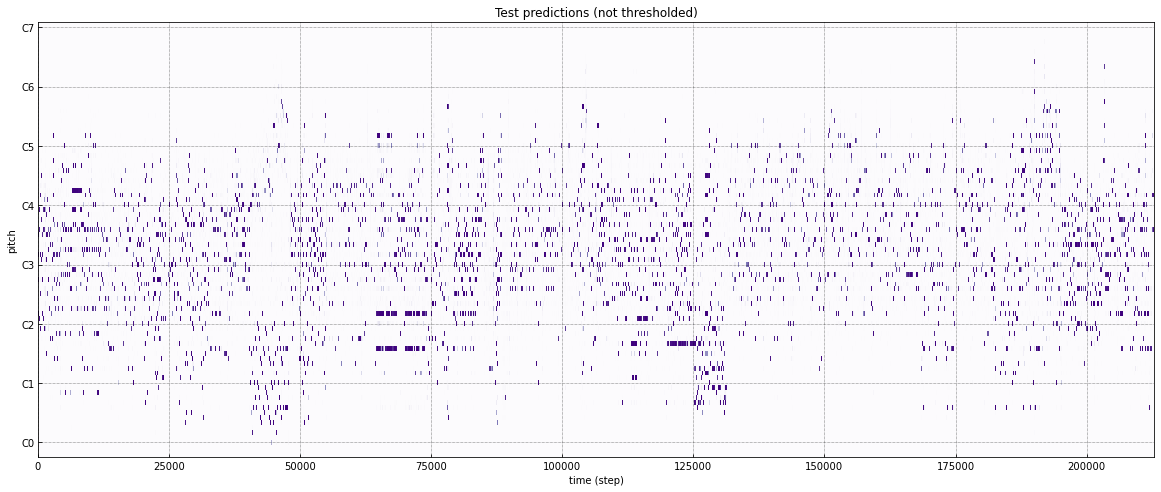

In [21]:
L = test.dataset[0].shape[0]
# L -= L % BS
predictions = model.predict(x=test.dataset[0][:L, :, :])
predictions_bin = dataset.threshold(predictions)
# print("Pred shape: ", predictions.shape)
# predictions = predictions[:, 88*0:88*1]  # First timestep
# print("Test shape: ", test.dataset[1].shape, "\n\n\n")
# test2 = test.dataset[1][:, :88]  # First timestep
# prediction_new = dataset.transpose(predictions)
# prediction_new = dataset.convert(prediction_new)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# plot_piano_roll(dataset.transpose(test2), 21, 109, ax1, FS)
# ax1.set_title('Test  target')

# plot_piano_roll(prediction_new, 21, 109, ax2, FS)
# ax2.set_title('Test predictions')

pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
                  cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test target (ground truth)")
plt.ylim(CROP)

pyplot_piano_roll(predictions[:, :NUM_NOTES],
                  cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test predictions (not thresholded)")
plt.ylim(CROP)

### Evaluate AUC - ROC
Evaluate metric on predictions and baseline with respect to the ground truth of test dataset

In [22]:
# Build baseline
if D == "data/JSB-Chorales-dataset":
    baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
    baseline.build_choral("test", step=st, t_step=num_ts, steps=st,
                       low_lim=LOW_LIM, high_lim=HIGH_LIM)

else:
    baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
    baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
                           down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

print("")
print("Baseline shape: ", baseline.dataset[1].shape)
print("Test shape: ", test.dataset[1].shape)

pred_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], predictions, NUM_NOTES)
base_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], baseline.dataset[1][:L, :], NUM_NOTES)
# pred_auc = ev_metrics.compute_auc(test.dataset[1], predictions, NUM_NOTES)
# base_auc = ev_metrics.compute_auc(test.dataset[1], baseline.dataset[1], NUM_NOTES)

Building baseline dataset (25 files)

Baseline shape:  (212837, 880)
Test shape:  (212837, 880)


OSError: [WinError 1] Funzione non corretta: 'T:\\Temp\\User\\tmpg9sezgou\\tmp.ps'

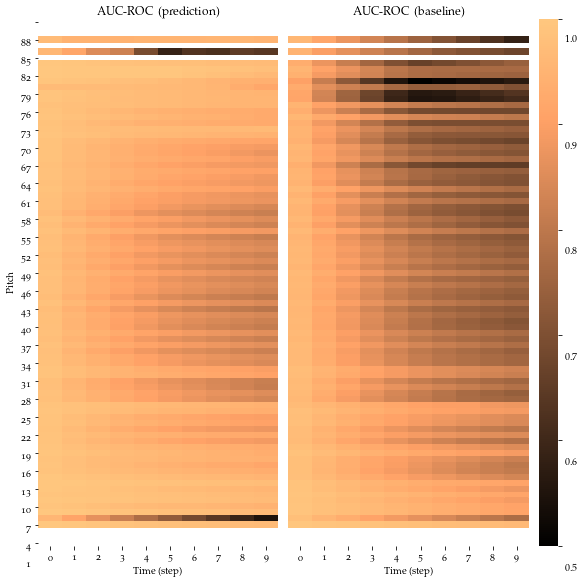

In [30]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

(88, 10)


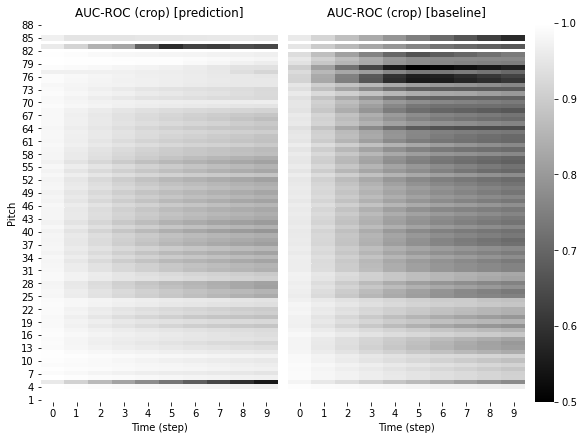

In [24]:
c1 = 0
c2 = 88
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

Predict. mean value: 0.9257206593871505
Baseline mean value: 0.8385388856996698


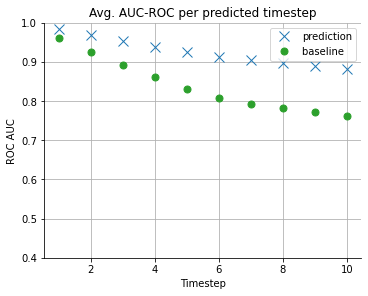

In [25]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.4, 1])
ax.set_ylim([0.4, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'aucDe222.eps', format='eps')
# fig.savefig(PLOTS / 'comp-ff-auc.pdf')
print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [26]:
np.mean(pred_auc[c1:c2])

0    0.984198
1    0.968107
2    0.953071
3    0.939118
4    0.925322
5    0.913239
6    0.905080
7    0.896893
8    0.889725
9    0.882454
dtype: float64

In [27]:
np.mean(base_auc[c1:c2])

0    0.960586
1    0.925168
2    0.892214
3    0.861089
4    0.830589
5    0.807184
6    0.792759
7    0.782087
8    0.771744
9    0.761968
dtype: float64

In [ ]:
# auc_df = pd.DataFrame(
#     {'pred': np.mean(pred_auc[c1:c2]),
#      'base': np.mean(base_auc[c1:c2])})
# auc_df['pred'].to_csv(('tables/ff-' + D[5:] + '-auc-pred-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# auc_df['base'].to_csv(('tables/ff-' + D[5:] + '-auc-base-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

### Piano rolls
- test data (input of the network)

- test target (ground truth)

- model predictions (output of the network)

- baseline (repetition of  the last input)

In [ ]:
t=0  # Timestep to visualize
plt.rcParams["figure.figsize"] = (10, 4)
pyplot_piano_roll(test.dataset[0][:, 0, :],
                  cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test data (input)")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'data.png'))

pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'pred.png'))

pyplot_piano_roll(test.dataset[1][:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test target (ground truth)")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'target.png'))

pyplot_piano_roll(baseline.dataset[1][:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Baseline")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'base.png'))

In [ ]:
t=0  # Timestep to visualize
plt.rcParams["figure.figsize"] = (10, 4)
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

t=4  # Timestep to visualize
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

t=7  # Timestep to visualize
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)], 
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

## Additional tests
Piano dataset, cmaj scale,...

In [ ]:
# midi_list2 = [x for x in os.listdir(P / "data") if x.endswith('.mid')]
# test_new = midi_list2[0:3]
# test = dataset.DataGenerator(test_new, P / "data",  fs=FS, bl=0, quant=Q)
# test.build_dataset("test", step=st, t_step=num_ts)
# print("Done")

In [ ]:
# plt.rcParams["figure.figsize"] = (20, 8)
# predictions = model.predict(x=test.dataset[0])
# predictions_bin = dataset.convert(predictions)

# print("Test shape: ", test.dataset[0].shape)
# print("Pred shape: ", predictions_bin.shape)

# pyplot_piano_roll(predictions_bin[:, :88], cmap="Purples")
# plt.title("Predictions")
# plt.ylim(CROP)

# pyplot_piano_roll(test.dataset[1][:, :88], cmap="Greens")
# plt.title("Test target (ground truth)")
# plt.ylim(CROP)

In [ ]:
# # Build baseline
# baseline = dataset.DataGenerator(test_new, P / "data",  fs=FS, bl=1, quant=Q)
# baseline.build_dataset("baseline", step=st, t_step=num_ts)
# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)
# print("Prediction shape: ", predictions_bin.shape)
# print("--- --- ---")
# pred_auc2 = ev_metrics.compute_auc(test.dataset[1], predictions)
# base_auc2 = ev_metrics.compute_auc(test.dataset[1], baseline.dataset[1])

In [ ]:
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(12, 8),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc2[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (prediction)')
# g2 = sns.heatmap(base_auc2[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (baseline)')
# ax1.get_shared_y_axes().join(ax1,ax2)

# print(pred_auc.shape)

In [ ]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

# ax.plot(range(1, num_ts + 1), np.mean(pred_auc2[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
# ax.plot(range(1, num_ts + 1), np.mean(base_auc2[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

# ax.set_ylim([0.4, 1])
# ax.set_ylim([0.4, 1])
# ax.legend()
# plt.title('Avg. AUC-ROC (crop) per predicted timestep')
# plt.xlabel('Timestep')
# # plt.xticks([0, 2, 4, 6, 8, 10])
# plt.ylabel('ROC AUC')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# name = 'auc' + str()
# # plt.savefig(PLOTS / 'auc.eps', format='eps')

# print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
# print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))